# **Dịch máy Anh-Pháp bằng mô hình Encoder-Decoder LSTM**

## 1. Chuẩn bị cho bài toán

### 1.1. Nhập các thư viện cần dùng
Yêu cầu hệ thống cho chương trình:

- Python 3.10.18
- Pytorch 2.1.0 (hỗ trợ CUDA nếu có)
- Torchtext 0.16.0
- NLTK 3.9.1
- Numpy 1.26.4
- Matplotlib 3.10.6
- spacy

In [1]:
# Cài thư viện với đúng phiên bản
!pip install torch==2.3.1 \
             torchtext==0.18.0 \
             numpy==1.26.4 \
             nltk==3.9.1 \
             matplotlib==3.10.6 \

# Tải model Spacy tiếng Anh và tiếng Pháp
!pip install spacy torch torchtext
!python -m spacy download en_core_web_sm
!python -m spacy download fr_core_news_sm

  ERROR: HTTP error 404 while getting https://github.com/explosion/spacy-models/releases/download/-en_core_web_sm/-en_core_web_sm.tar.gz
ERROR: Could not install requirement https://github.com/explosion/spacy-models/releases/download/-en_core_web_sm/-en_core_web_sm.tar.gz because of HTTP error 404 Client Error: Not Found for url: https://github.com/explosion/spacy-models/releases/download/-en_core_web_sm/-en_core_web_sm.tar.gz for URL https://github.com/explosion/spacy-models/releases/download/-en_core_web_sm/-en_core_web_sm.tar.gz
  ERROR: HTTP error 404 while getting https://github.com/explosion/spacy-models/releases/download/-fr_core_news_sm/-fr_core_news_sm.tar.gz
ERROR: Could not install requirement https://github.com/explosion/spacy-models/releases/download/-fr_core_news_sm/-fr_core_news_sm.tar.gz because of HTTP error 404 Client Error: Not Found for url: https://github.com/explosion/spacy-models/releases/download/-fr_core_news_sm/-fr_core_news_sm.tar.gz for URL https://github.co

In [2]:
import os
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
import random, copy
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence
from torch.utils.data import Dataset, DataLoader
from torchtext.vocab import build_vocab_from_iterator
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import matplotlib.pyplot as plt
import spacy

/usr/local/lib/python3.12/dist-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.12/dist-packages/torchtext/utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)


### 1.2. Chọn thiết bị chạy trên Pytorch

In [3]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Dùng thiết bị:", DEVICE)

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Dùng thiết bị: cuda


### 1.3. Load tokenizer spaCy thủ công

In [4]:
spacy_en = spacy.load("en_core_web_sm")
spacy_fr = spacy.load("fr_core_news_sm")

def en_tokenizer(text):
    return [tok.text.lower() for tok in spacy_en.tokenizer(text)]

def fr_tokenizer(text):
    return [tok.text.lower() for tok in spacy_fr.tokenizer(text)]

### 1.4. Đọc dữ liệu từ thư mục data

In [5]:
DATA_DIR = 'data'

def read_file(path):
    with open(path, 'r', encoding='utf-8') as f:
        return [line.strip() for line in f if line.strip()]

train_en = read_file(os.path.join(DATA_DIR, 'train.en'))
train_fr = read_file(os.path.join(DATA_DIR, 'train.fr'))
val_en   = read_file(os.path.join(DATA_DIR, 'val.en'))
val_fr   = read_file(os.path.join(DATA_DIR, 'val.fr'))
test_en  = read_file(os.path.join(DATA_DIR, 'test.en'))
test_fr  = read_file(os.path.join(DATA_DIR, 'test.fr'))

print(f"Train: {len(train_en)} cặp")
print(f"Valid: {len(val_en)} cặp")
print(f"Test : {len(test_en)} cặp")

Train: 29000 cặp
Valid: 1014 cặp
Test : 1071 cặp


### 1.5. Xây dựng từ vựng

In [6]:
def yield_tokens(sentences, tokenizer):
    for sent in sentences:
        yield tokenizer(sent)

en_vocab = build_vocab_from_iterator(yield_tokens(train_en, en_tokenizer), specials=['<unk>', '<pad>', '<sos>', '<eos>'], min_freq=2)
fr_vocab = build_vocab_from_iterator(yield_tokens(train_fr, fr_tokenizer), specials=['<unk>', '<pad>', '<sos>', '<eos>'], min_freq=2)

en_vocab.set_default_index(en_vocab['<unk>'])
fr_vocab.set_default_index(fr_vocab['<unk>'])

print(f"Vocab Anh: {len(en_vocab)}")
print(f"Vocab Pháp: {len(fr_vocab)}")

Vocab Anh: 5893
Vocab Pháp: 6470


## 2. Xử lý dữ liệu

In [7]:
def text_to_indices(text, vocab, tokenizer):
    return [vocab['<sos>']] + [vocab[tok] for tok in tokenizer(text)] + [vocab['<eos>']]

class TranslationDataset(Dataset):
    def __init__(self, src_sents, trg_sents):
        self.src_sents = src_sents
        self.trg_sents = trg_sents

    def __len__(self):
        return len(self.src_sents)

    def __getitem__(self, idx):
        return self.src_sents[idx], self.trg_sents[idx]

def collate_fn(batch):
    src_batch, trg_batch = [], []
    for src, trg in batch:
        src_batch.append(torch.tensor(text_to_indices(src, en_vocab, en_tokenizer)))
        trg_batch.append(torch.tensor(text_to_indices(trg, fr_vocab, fr_tokenizer)))
    src_batch = pad_sequence(src_batch, padding_value=en_vocab['<pad>'])
    trg_batch = pad_sequence(trg_batch, padding_value=fr_vocab['<pad>'])
    return src_batch, trg_batch

BATCH_SIZE = 128

train_dataset = TranslationDataset(train_en, train_fr)
val_dataset   = TranslationDataset(val_en, val_fr)
test_dataset  = TranslationDataset(test_en, test_fr)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

## 3. Xây dựng mô hình

### 3.1. Encoder

In [8]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers=2, dropout=0.5):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.LSTM(emb_dim, hid_dim, num_layers=n_layers, dropout=dropout if n_layers > 1 else 0)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src):
        embedded = self.dropout(self.embedding(src))
        outputs, (hidden, cell) = self.rnn(embedded)
        return hidden, cell

### 3.2. Decoder

In [9]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers=2, dropout=0.5):
        super().__init__()
        self.output_dim = output_dim
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.rnn = nn.LSTM(emb_dim, hid_dim, num_layers=n_layers, dropout=dropout if n_layers > 1 else 0)
        self.fc_out = nn.Linear(hid_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden, cell):
        input = input.unsqueeze(0) if input.dim() == 1 else input
        embedded = self.dropout(self.embedding(input))
        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))
        prediction = self.fc_out(output.squeeze(0))
        return prediction, hidden, cell

### 3.3. Seq2Seq

In [10]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        batch_size = trg.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.fc_out.out_features

        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        hidden, cell = self.encoder(src)

        input = trg[0, :]
        for t in range(1, trg_len):
            output, hidden, cell = self.decoder(input, hidden, cell)
            outputs[t] = output
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.argmax(1)
            input = trg[t] if teacher_force else top1
        return outputs

## 4. Huấn luyện

### 4.1. Khởi tạo mô hình

In [11]:
INPUT_DIM = len(en_vocab)
OUTPUT_DIM = len(fr_vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
DROPOUT = 0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, n_layers=N_LAYERS, dropout=DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, n_layers=N_LAYERS, dropout=DROPOUT)

model = Seq2Seq(enc, dec, DEVICE).to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss(ignore_index=fr_vocab['<pad>'])

print(f"Mô hình: Encoder-Decoder LSTM | 2 tầng | Hidden {HID_DIM} | Emb {ENC_EMB_DIM}")
print(f"Tổng tham số: {sum(p.numel() for p in model.parameters()):,}")

Mô hình: Encoder-Decoder LSTM | 2 tầng | Hidden 512 | Emb 256
Tổng tham số: 13,840,454


### 4.2. Hàm huấn luyện

In [12]:
def train(model, iterator, optimizer, loss_fn, clip=1.0):
    model.train()
    epoch_loss = 0
    for batch in iterator:
        src, trg = batch
        src, trg = src.to(DEVICE), trg.to(DEVICE)

        optimizer.zero_grad()
        output = model(src, trg, teacher_forcing_ratio=0.5)

        output_dim = output.shape[-1]
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)

        loss = loss_fn(output, trg)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(iterator)

### 4.3. Hàm đánh giá

In [13]:
def evaluate(model, iterator, loss_fn):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for batch in iterator:
            src, trg = batch
            src, trg = src.to(DEVICE), trg.to(DEVICE)

            output = model(src, trg, teacher_forcing_ratio=0)

            output_dim = output.shape[-1]
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)

            loss = loss_fn(output, trg)
            epoch_loss += loss.item()
    return epoch_loss / len(iterator)

### 4.4. Chạy huấn luyện

In [14]:
N_EPOCHS = 20
patience = 3
best_valid_loss = float('inf')
patience_counter = 0
best_model_path = "best_model.pth"

train_losses = []
valid_losses = []

print("Bắt đầu huấn luyện với Early Stopping (patience = 3)...\n")

for epoch in range(1, N_EPOCHS + 1):
    train_loss = train(model, train_loader, optimizer, loss_fn, clip=1.0)
    valid_loss = evaluate(model, val_loader, loss_fn)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    # Lưu model tốt nhất
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), best_model_path)
        patience_counter = 0
        print(f"Epoch: {epoch:02} | Train Loss: {train_loss:.3f} | Val. Loss: {valid_loss:.3f}  ← BEST MODEL SAVED")
    else:
        patience_counter += 1
        print(f"Epoch: {epoch:02} | Train Loss: {train_loss:.3f} | Val. Loss: {valid_loss:.3f}  (patience {patience_counter}/{patience})")

    # Early stopping
    if patience_counter >= patience:
        print(f"\nEarly stopping! Không cải thiện val_loss trong {patience} epoch liên tiếp.")
        print("→ Dừng huấn luyện tại epoch {epoch}")
        break

print(f"\nHuấn luyện hoàn tất! Best Val. Loss: {best_valid_loss:.3f}")
print("Đã lưu mô hình tốt nhất vào:", best_model_path)

Bắt đầu huấn luyện với Early Stopping (patience = 3)...

Epoch: 01 | Train Loss: 5.119 | Val. Loss: 4.978  ← BEST MODEL SAVED
Epoch: 02 | Train Loss: 4.494 | Val. Loss: 4.879  ← BEST MODEL SAVED
Epoch: 03 | Train Loss: 4.095 | Val. Loss: 4.644  ← BEST MODEL SAVED
Epoch: 04 | Train Loss: 3.790 | Val. Loss: 4.325  ← BEST MODEL SAVED
Epoch: 05 | Train Loss: 3.553 | Val. Loss: 4.214  ← BEST MODEL SAVED
Epoch: 06 | Train Loss: 3.348 | Val. Loss: 4.068  ← BEST MODEL SAVED
Epoch: 07 | Train Loss: 3.206 | Val. Loss: 3.956  ← BEST MODEL SAVED
Epoch: 08 | Train Loss: 3.079 | Val. Loss: 3.880  ← BEST MODEL SAVED
Epoch: 09 | Train Loss: 2.948 | Val. Loss: 3.838  ← BEST MODEL SAVED
Epoch: 10 | Train Loss: 2.827 | Val. Loss: 3.742  ← BEST MODEL SAVED
Epoch: 11 | Train Loss: 2.758 | Val. Loss: 3.690  ← BEST MODEL SAVED
Epoch: 12 | Train Loss: 2.647 | Val. Loss: 3.691  (patience 1/3)
Epoch: 13 | Train Loss: 2.587 | Val. Loss: 3.661  ← BEST MODEL SAVED
Epoch: 14 | Train Loss: 2.489 | Val. Loss: 3.634  

### 4.5. Vẽ biểu đồ loss

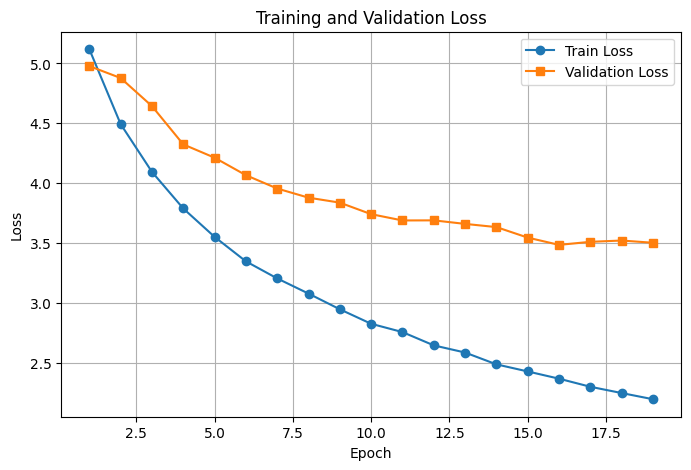

In [15]:
plt.figure(figsize=(8, 5))

plt.plot(range(1, len(train_losses) + 1), train_losses, label="Train Loss", marker='o')
plt.plot(range(1, len(valid_losses) + 1), valid_losses, label="Validation Loss", marker='s')

plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

plt.show()

## 5. Đánh giá mô hình

### 5.1. Hàm dịch câu (với beam search đơn giản)

In [16]:
def translate(sentence, beam_width=3, max_len=50):
    model.eval()
    with torch.no_grad():
        src_indices = text_to_indices(sentence, en_vocab, en_tokenizer)
        src = torch.tensor(src_indices).unsqueeze(1).to(DEVICE)

        hidden, cell = model.encoder(src)

        beams = [([fr_vocab['<sos>']], 0.0, hidden, cell)]

        for _ in range(max_len - 1):
            new_beams = []

            for seq, score, h, c in beams:

                if seq[-1] == fr_vocab['<eos>']:
                    new_beams.append((seq, score, h, c))
                    continue

                input_token = torch.tensor([[seq[-1]]], dtype=torch.long).to(DEVICE)

                output, hidden_new, cell_new = model.decoder(input_token, h, c)

                log_probs = torch.log_softmax(output, dim=-1).squeeze(0)
                topk_log_probs, topk_idx = log_probs.topk(beam_width)

                for i in range(beam_width):
                    token_idx = topk_idx[i].item()
                    new_score = score + topk_log_probs[i].item()
                    new_seq = seq + [token_idx]
                    new_beams.append((new_seq, new_score, hidden_new, cell_new))

            beams = sorted(new_beams, key=lambda x: x[1], reverse=True)[:beam_width]

            if beams[0][0][-1] == fr_vocab['<eos>']:
                break

        best_seq = beams[0][0]

        if best_seq[-1] == fr_vocab['<eos>']:
            best_seq = best_seq[1:-1]
        else:
            best_seq = best_seq[1:]

        translated = ' '.join(fr_vocab.get_itos()[idx] for idx in best_seq)
        return translated

### 5.2. Đánh giá vài ví dụ

In [17]:
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

test_fr_tok = [fr_tokenizer(sentence) for sentence in test_fr]
smooth = SmoothingFunction().method1

import math
from collections import Counter

def bleu_score(reference, hypothesis, max_n=4):
    if len(hypothesis) == 0:
        return 0.0

    weights = [0.25] * max_n

    score_log_sum = 0

    for n in range(1, max_n + 1):
        ref_ngrams = Counter([" ".join(reference[i:i+n]) for i in range(len(reference)-n+1)])
        hyp_ngrams = Counter([" ".join(hypothesis[i:i+n]) for i in range(len(hypothesis)-n+1)])

        overlap = sum((hyp_ngrams & ref_ngrams).values())
        total = max(sum(hyp_ngrams.values()), 1)

        precision = overlap / total
        score_log_sum += weights[n-1] * math.log(precision + 1e-12)

    ref_len = len(reference)
    hyp_len = len(hypothesis)

    bp = 1 if hyp_len > ref_len else math.exp(1 - ref_len / hyp_len)

    bleu = bp * math.exp(score_log_sum)
    return bleu


for i in range(5):
    src = test_en[i]
    ref = test_fr_tok[i]
    pred = translate(src)
    b = bleu_score(ref, pred.split())

    print(f"EN: {src}")
    print(f"FR actual: {' '.join(ref)}")
    print(f"FR predicted: {pred}")
    print(f"BLEU: {b:.4f}")
    print("-----------------------")

EN: A young man participates in a career while the subject who records it smiles.
FR actual: un jeune homme participe à une course pendant que le sujet qui le filme sourit .
FR predicted: un jeune homme participe dans un champ tandis que tandis que d' autres regardent .
BLEU: 0.1703
-----------------------
EN: The man is scratching the back of his neck while looking for a book in a book store.
FR actual: l' homme se gratte l' arrière du cou tout en cherchant un livre dans une librairie .
FR predicted: l' homme est sur le visage de son épaule , tandis qu' un homme est en train .
BLEU: 0.0000
-----------------------
EN: A person wearing goggles and a hat is sled riding.
FR actual: une personne portant des lunettes de protection et un chapeau fait de la luge .
FR predicted: une personne portant des lunettes et un casque fait du vélo .
BLEU: 0.3024
-----------------------
EN: A girl in a pink coat and flowered goloshes sledding down a hill.
FR actual: une fille avec une veste rose et des g

### 5.3. Tính BLEU và Perplexity trung bình

In [18]:
def evaluate_bleu():
    bleus = []
    for i in range(len(test_en)):
        pred = translate(test_en[i])
        ref = test_fr_tok[i]
        bleus.append(bleu_score(ref, pred.split()))
    return sum(bleus) / len(bleus)

def evaluate_ppl():
    test_loss = evaluate(model, test_loader, loss_fn)
    return np.exp(test_loss)

mean_bleu = evaluate_bleu()
ppl = evaluate_ppl()

print(f"Average BLEU: {mean_bleu:.4f}")
print(f"Average Perplexity: {ppl:.4f}")

Average BLEU: 0.0738
Average Perplexity: 90.9985
